### This is just a shap and model explanation notebook, you neednot run it as it takes a lot of time (deepshap is slow :( ). The input to this notebook is the data of this competition and the trained and saved model in the training notebook.

In [2]:
!pip install --upgrade plotly plotnine
!pip install fastinference

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
  Attempting uninstall: mizani
    Found existing installation: mizani 0.10.0
    Uninstalling mizani-0.10.0:
      Successfully uninstalled mizani-0.10.0
  Attempting uninstall: plotnine
    Found existing installation: plotnine 0.10.1
    Uninstalling plotnine-0.10.1:
      Successfully uninstalled plotnine-0.10.1


In [3]:
import os
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from fastai.tabular.all import * 
from fastinference.tabular import *
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, SplineTransformer


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

warnings.simplefilter("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     os.environ['CUDA_LAUNCH_BLOCKING'] = str(1)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
seed_everything(seed=42)

In [5]:
set_seed(42)
seed_everything(seed=42)

df_train = pd.read_csv("/kaggle/input/ecm-itu-zindi-kp-data/imgs_2023071012133740345.csv",parse_dates=['Time'])
df_test = pd.read_csv("/kaggle/input/ecm-itu-zindi-kp-data/imgs_202307101549519358.csv",parse_dates=['Time'])
df_cell = pd.read_csv("/kaggle/input/ecm-itu-zindi-kp-data/imgs_2023071012130978799.csv",parse_dates=['Time'])
df_bs = pd.read_csv("/kaggle/input/ecm-itu-zindi-kp-data/imgs_2023071012123392536.csv")
df_features = df_cell.merge(df_bs,on=['BS','CellName'],how='outer')
df_features = df_features[df_features['CellName']=='Cell0'].reset_index(drop=True)
df_test['split'] = 'test'
df_train['split'] = 'train'
df_total = pd.concat([df_train,df_test],ignore_index=True)
df_total = df_total.merge(df_features,on=['BS','Time'],how='left')
df_total['ID'] = df_total['Time'].astype(str)+"_"+df_total['BS']
df_total['BS'] = df_total['BS'].str.replace(r'[a-zA-Z_]', '', regex=True).astype(int)
for col in ['RUType','Mode']:
    df_total[col] = df_total[col].str.replace(r'[a-zA-Z]', '', regex=True).astype(int)

df_total.sort_values(['BS','Time'], ascending=True,ignore_index=True,inplace=True)
df_total['day'] = df_total['Time'].dt.day
df_total['weekday_number'] = df_total['Time'].dt.weekday
df_total['hour'] = df_total['Time'].dt.hour

hour_df = df_total[['hour']].copy()
splines = periodic_spline_transformer(24, n_splines=12).fit_transform(hour_df)
splines_df = pd.DataFrame(splines,columns=[f"hour_spline_{i}" for i in range(splines.shape[1])])
df_total = pd.concat([df_total,splines_df],axis=1)

df_total = df_total.sort_values(['BS','Time'],ascending=True,ignore_index=True)
all_shits = list(np.arange(1,4)) # 
for shift_i in tqdm(all_shits):
    for col in ['load','ESMode1','ESMode2','ESMode3','ESMode6','Time','Energy']:
        df_total[f'{col}_T-{shift_i}'] = df_total.groupby(['BS'])[col].shift(shift_i)        
for shift_i in tqdm(all_shits):
    df_total[f'Time_T-{shift_i}_hours_elapsed'] = (df_total[f'Time_T-{shift_i}']-df_total['Time']).dt.total_seconds() / 3600
    del df_total[f'Time_T-{shift_i}']
print(df_total.shape)

num_bins = 100
df_total['load_bin'] = pd.cut(df_total['load'],bins=[round(i,2) for i in list(np.arange(0,1.01,0.01))],labels=[f'{i}' for i in range(num_bins)])
df_total['load_bin'] = df_total['load_bin'].astype(float).fillna(-1).astype(int)

print(df_total.shape)

100%|██████████| 3/3 [00:00<00:00, 237.30it/s]

(118768, 56)
(118768, 57)


In [6]:
set_seed(42)
seed_everything(seed=42)

from scipy.signal import savgol_filter as sg
from scipy.signal import sosfiltfilt, butter, sosfilt, sosfilt_zi

def add_sg(df):
    w = 5 #5
    p = 3 #2
    for si in tqdm(df.BS.unique()):
        index = df.BS == si
        df.loc[index, 'load_smooth'] = sg(df[index].load, w, p)
        df.loc[index, 'load_diff'] = sg(df[index].load, w, p, 1)
        df.loc[index, 'load_diff2'] = sg(df[index].load, w, p, 2)
        df.loc[index, 'load_diff3'] = sg(df[index].load, w, p, 3)

add_sg(df_total)
print(df_total.shape)

def add_sosfiltfilt(df):
    for si in tqdm(df.BS.unique()):
        index = df.BS == si
        sos=butter(4, 0.125, output='sos')
        sos8 = butter(8, 0.125, output='sos')
        zi = np.array(df[index].load[:4]).mean() * sosfilt_zi(sos8)
        df.loc[index, 'load_sosfiltfilt'] = sosfiltfilt(sos,df[index].load)
        df.loc[index, 'load_sosfilt'], _ = sosfilt(sos8, df[index].load, zi=zi)

add_sosfiltfilt(df_total)
print(df_total.shape)

100%|██████████| 1020/1020 [00:08<00:00, 125.20it/s]


(118768, 61)


100%|██████████| 1020/1020 [00:07<00:00, 144.46it/s]

(118768, 63)


In [7]:
set_seed(42)
seed_everything(seed=42)

df_total.drop(columns=['w','CellName','ESMode4','Time'],inplace=True)

id_variable = 'ID'
version_nb = 'v4'
TARGET = 'Energy'

train_df = df_total[df_total['split']=='train'].reset_index(drop=True)
test_df = df_total[df_total['split']=='test'].reset_index(drop=True)
train_cols = [i for i in train_df if i not in ['Time','CellName','ID','Energy','split','w','BS','ESMode6']]

categorical_cols = ['RUType','Mode','load_bin']

print(train_df[train_cols].shape, test_df[train_cols].shape)

(92629, 54) (26139, 54)


In [8]:
set_seed(42)
seed_everything(seed=42)

remove_non_unique_cols = []
print('train single values ..')
for col in train_df:
    if col in train_cols and col not in ['ESMode5']:
        if train_df[col].nunique()<=1:
            remove_non_unique_cols.append(col)
            print(col,":",train_df[col].nunique())
print('test single values ..')
for col in test_df:
    if col in train_cols and col not in ['ESMode5']:
        if test_df[col].nunique()<=1:
            remove_non_unique_cols.append(col)
            print(col,":",test_df[col].nunique())

print('\n',remove_non_unique_cols)

for col in train_df:
    if col in train_cols:
        if train_df[col].isnull().sum()/len(train_df)>=0.95:
            print(col,":",train_df[col].isnull().sum()/len(train_df))
            remove_non_unique_cols.append(col)

for col in test_df:
    if col in train_cols:
        if test_df[col].isnull().sum()/len(test_df)>=0.95:
            print(col,":",test_df[col].isnull().sum()/len(test_df))
            remove_non_unique_cols.append(col)
            
print(len(train_cols))
train_cols = [col for col in train_cols if col not in remove_non_unique_cols]
print(len(train_cols))
print(train_cols)

train single values ..
test single values ..

 []
54
54
['load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode5', 'RUType', 'Mode', 'Frequency', 'Bandwidth', 'Antennas', 'TXpower', 'day', 'weekday_number', 'hour', 'hour_spline_0', 'hour_spline_1', 'hour_spline_2', 'hour_spline_3', 'hour_spline_4', 'hour_spline_5', 'hour_spline_6', 'hour_spline_7', 'hour_spline_8', 'hour_spline_9', 'hour_spline_10', 'hour_spline_11', 'load_T-1', 'ESMode1_T-1', 'ESMode2_T-1', 'ESMode3_T-1', 'ESMode6_T-1', 'Energy_T-1', 'load_T-2', 'ESMode1_T-2', 'ESMode2_T-2', 'ESMode3_T-2', 'ESMode6_T-2', 'Energy_T-2', 'load_T-3', 'ESMode1_T-3', 'ESMode2_T-3', 'ESMode3_T-3', 'ESMode6_T-3', 'Energy_T-3', 'Time_T-1_hours_elapsed', 'Time_T-2_hours_elapsed', 'Time_T-3_hours_elapsed', 'load_bin', 'load_smooth', 'load_diff', 'load_diff2', 'load_diff3', 'load_sosfiltfilt', 'load_sosfilt']


In [9]:
set_seed(42)
seed_everything(seed=42)

Nfold = 10
Inference=False

if Inference:
    print('Data has been splitted...')
else:
    train_df['fold'] = 0
    strafy_bin = train_df['BS'].astype('int')

    skf = GroupKFold(n_splits = Nfold)
    for i, (_, train_index) in enumerate(skf.split(train_df.index,train_df.index, strafy_bin)):
        train_df.loc[train_index, 'fold'] = i  

## FAST AI Inference

In [11]:
model_path = '/kaggle/input/ecm-zindi-kp-v4/'

### Base station Analysis for Fold 4

In [12]:
fold = 4


train_df_fast = train_df[train_cols + [TARGET]].copy()
test_df = test_df.copy()
for col in train_df_fast.columns:
    if col not in categorical_cols:
        train_df_fast[col] = train_df_fast[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)
    else:
        # Impute missing categorical values with the most frequent category
        most_frequent_category = train_df_fast[col].mode().iloc[0]
        train_df_fast[col] = train_df_fast[col].fillna(most_frequent_category)
        test_df[col] = test_df[col].fillna(most_frequent_category)

train_df_fast[categorical_cols] = train_df_fast[categorical_cols].astype('category')
test_df[categorical_cols] = test_df[categorical_cols].astype('category')

cont_nn = train_cols.copy()
for col in categorical_cols:
    cont_nn.remove(col)

cat_nn = categorical_cols



In [13]:
layers =  [256, 512, 1024, 512, 256] #[256, 512, 1024, 512, 256]
train_idx = train_df.loc[train_df['fold']!=fold, :].index
valid_idx = train_df.loc[train_df['fold']==fold, :].index
splits = (L(list(train_idx)), L(list(valid_idx)))
dls = TabularPandas(train_df_fast, [Categorify, Normalize], cat_nn, cont_nn, splits = splits, y_names=TARGET,reduce_memory=False).dataloaders(1024)


In [14]:
if os.path.isfile(model_path + f'models/nn_model_{fold}.pth'):
    learn = tabular_learner(dls, layers=layers, n_out=1, path = model_path)
    learn.load(f'nn_model_{fold}')

### FAST AI Model Summary

In [15]:
print(learn.summary())

TabularModel (Input shape: 1024 x 3)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 7            
Embedding                                 91         True      
____________________________________________________________________________
                     1024 x 3            
Embedding                                 9          True      
____________________________________________________________________________
                     1024 x 21           
Embedding                                 2142       True      
Dropout                                                        
BatchNorm1d                               102        True      
____________________________________________________________________________
                     1024 x 256          
Linear                                    20992      True      
ReLU                                                           
BatchNorm1d                               512       

## Model Explainability on Real world Data


As per the challenge and solution we have proposed, we will begin to understand and focus more on the Objectives of the Challenge for Saving predictions.

Currently the main objectives are as follows

* **1. Energy Consumption Estimation** : Developing machine learning models capable of estimating the energy consumption of various base station products. This involves considering factors such as engineering configurations, traffic conditions, and energy-saving methods.

* **2. Generalization Across Products** : Ensure that the models can generalize their energy consumption estimations to new base station products based on data from existing ones. The models should accurately predict energy consumption for products not previously encountered.

* **3. Generalization Across Configurations**: Enable the models to predict energy consumption for base stations with different configurations, even when the training data provides limited information about these specific configurations.

The overall goal is to create machine learning solutions that accurately estimate and optimize energy consumption in diverse base station scenarios, contributing to more energy-efficient and sustainable 4G and 5G network deployments.

Towards the end of the SHAP Interpretation we will Try to target these objectives to provide a holistic picture and Feature importances with a small test data divided among the following

* **NEW Base Stations** : SHAP Interpretation for Importance of features for NEW Base stations which dosent have a history. This will summarize and give us an indication towards points **2** and **3** which is **Generalization Across Products** and **Generalization Across Configurations**. Since there are around 97 Base stations which dosent have a history and are totaly new Base stations with different configurable parameters. This approach can give a good explanation on which features re they dependent.

* **EXISTING Base Stations** SHAP Interpretation for Importance of features for Existing Base stations which have a time based history of ENergy consumptions on an hourly basis. This will summarize and give us an indication towards points **1** **Energy Consumption Estimation**

In [16]:
new_BS = test_df[~test_df['BS'].isin(train_df['BS'])]
exis_BS = test_df[test_df['BS'].isin(train_df['BS'])]

In [17]:
new_BS['BS'].sample(10)

488        13
23625     841
10507     363
24731     916
24129     879
25799    1000
24064     876
26036    1015
24776     919
18763     651
Name: BS, dtype: int64

In [18]:
exis_BS['BS'].sample(10)

19488    678
14588    506
11396    394
22629    792
18875    654
3253     111
13187    458
8199     286
13724    477
345       12
Name: BS, dtype: int64

### SHAP Interpretation

For sample lets take some Base station values from test data which
1. HAVE NO History in Train data regarding their Energy consumption and are completely new Base stations
    * **BS - 1016**
2. HAVE history of Energy consumption on an hourly basis
    * **BS - 143**

In [19]:
exp_new = ShapInterpretation(learn, new_BS[new_BS['BS']==1016])
exp_exis = ShapInterpretation(learn, exis_BS[exis_BS['BS']==143])

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

#### SHAP Summary plot 
[REFER](https://christophm.github.io/interpretable-ml-book/shap.html)

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.


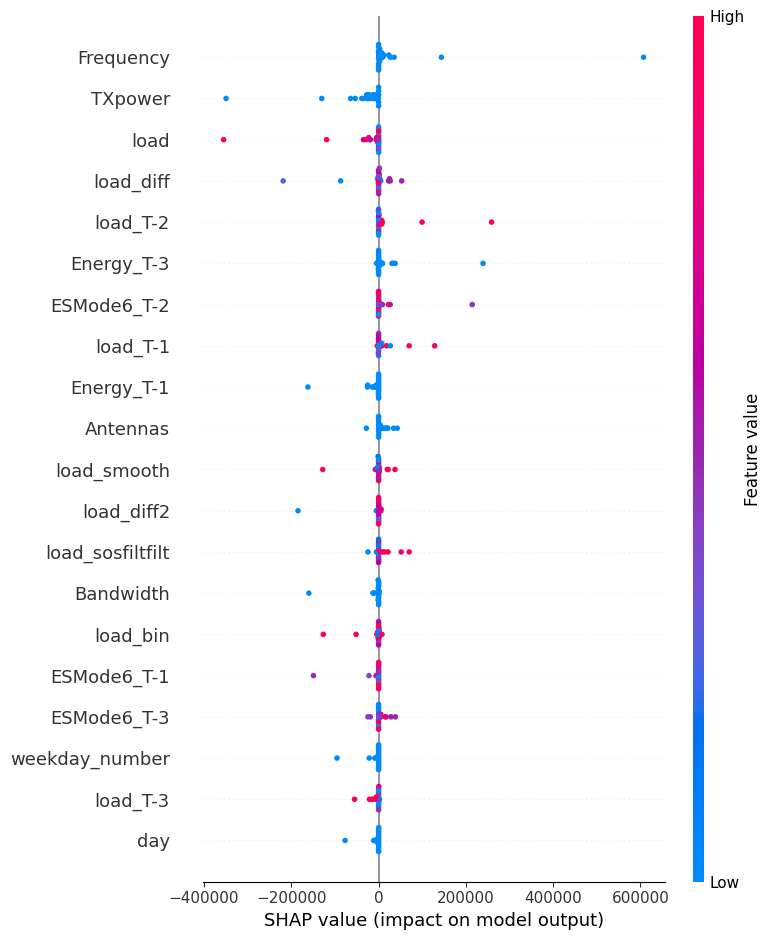

In [20]:
exp_new.summary_plot()

Lets understand some insights about our model that which Feature is important for **NEW Base stations**.

1. Low values of **Frequency** have high impact on the model output, which can suggest that low Frequency have low Energy consumption
2. Low values of **TXPower** tends to have not much impact towards the model, thought suggested as a good indicator
3. High values of **Load** tends to have low impact (though good importance), but HIGH values of **load_T-2** and **load_diff** have a very impact on model output, suggesting the Energy is increasing based on Lagged values of Load.
4. Since, these are new Base stations and dosent have any Energy consumption or (value=0 for Lagged Variables), therefore we can see that the values of all Energy Lagged values such as **Energy_T-1**, **Energy_T-2** and so on have very low Values and not much predictive in terms of raw features like **Frequency** and **TXPower**
5. We can also see, some of the smoothing variables for **load**such as **load_diff2** and **load_sosfiltflit** are also having good impact on model with higher values suggesting even good predictive ability.
6. **ESMode** lag variables are holding good impact on model



**NOTE** : The SHAP interpretation is done on **BS-1016** which had around **24 samples**, the results may vary accordingly if we try to look for another BS

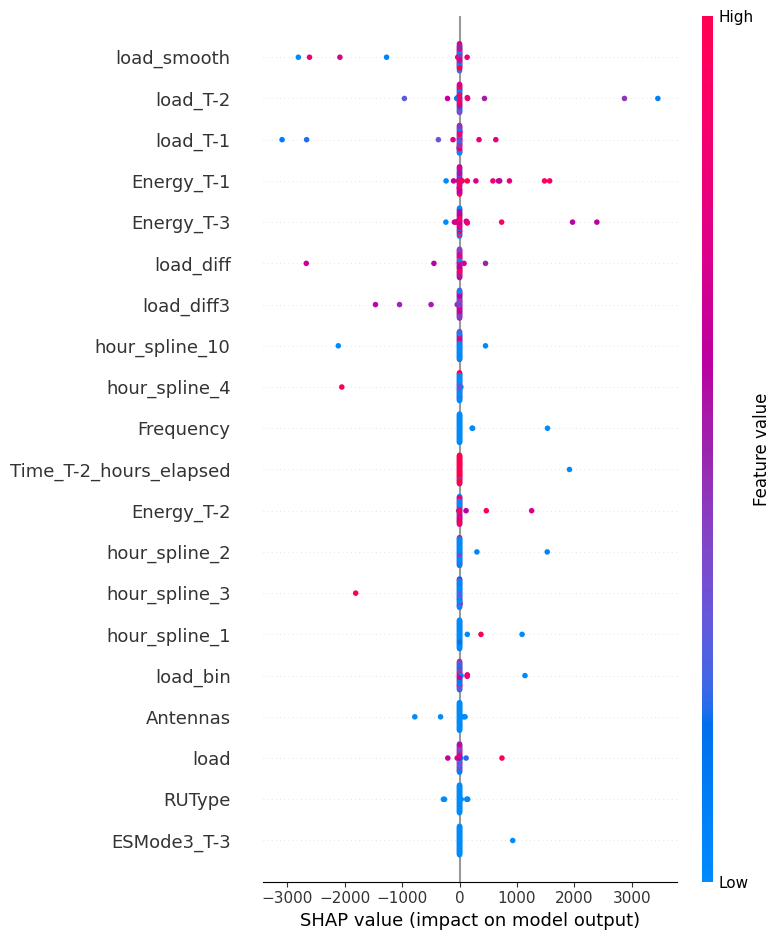

In [21]:
exp_exis.summary_plot()

Lets understand some insights about our model that which Feature is important for **EXISTING Base stations**.

1. Smoothening features have a very high impact on the model, since **load_smooth** with high and low values have good impact.
2. HIGH and LOW values of **load_T-1**,**load_T-2** and **load_diff** have a very impact on model output, suggesting the Energy is increasing based on Lagged values of Load.
3. the INTERESTINg Part of this analysis is feature importance of **Energy_T-1**, **Energy_T-2** and **Energy_T-3** for which HIGH values for **Energy_T-1** has a very good impact on model performance suggesting very goo correlation. **This particular is the difference betweein the NEW BS and EXISTING BS.**
4. Considering the **hour_spline** features which are also indicating good model insights.


**NOTE** : The SHAP interpretation is done on **BS-143** which had around **24 samples**, the results may vary accordingly if we try to look for another BS

### Clustering Shapley Values

You can cluster your data with the help of Shapley values. The goal of clustering is to find groups of similar instances. Normally, clustering is based on features. Features are often on different scales. For example, height might be measured in meters, color intensity from 0 to 100 and some sensor output between -1 and 1. The difficulty is to compute distances between instances with such different, non-comparable features.

SHAP clustering works by clustering the Shapley values of each instance. This means that you cluster instances by explanation similarity. All SHAP values have the same unit – the unit of the prediction space. You can use any clustering method. The following example uses hierarchical agglomerative clustering to order the instances.

The plot consists of many force plots, each of which explains the prediction of an instance. We rotate the force plots vertically and place them side by side according to their clustering similarity.

In [22]:
exp_new.force_plot()

In [23]:
exp_exis.force_plot()

Stacked SHAP explanations clustered by explanation similarity. Each position on the x-axis is an instance of the data. Red SHAP values increase the prediction, blue values decrease it. One cluster stands out

## Keras Model

In [24]:
from tensorflow import keras
from keras import backend as K
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras.backend import sigmoid
from tensorflow.keras import backend as K

set_seed(42)
seed_everything(seed=42)
tf.random.set_seed(42)

In [25]:
set_seed(42)
seed_everything(seed=42)
tf.random.set_seed(42)

def mean_absolute_error(y_true, y_pred):
         return K.mean(K.abs( (y_true - y_pred)))

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=50, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.25, patience=8, verbose=0,
    mode='min')

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

def mish(x, beta = 1):
    return (x * K.tanh(K.softplus(x)))


get_custom_objects().update({'swish': Activation(swish)})
get_custom_objects().update({'mish': Activation(mish)})

In [26]:
from keras.models import load_model
# load_model('/kaggle/input/ecm-zindi-kp-v4/Keras_NN_1.h5')
fold=4
model = keras.models.load_model(model_path + f'/Keras_NN_{fold}.h5', 
                                             custom_objects={'swish': swish, 'Activation': Activation, 
                                                             'mean_absolute_error':mean_absolute_error})

In [27]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RUType (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Mode (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 load_bin (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 RUType_embedding (Embedding)   (None, 1, 16)        192         ['RUType[0][0]']                 
                                                                                            

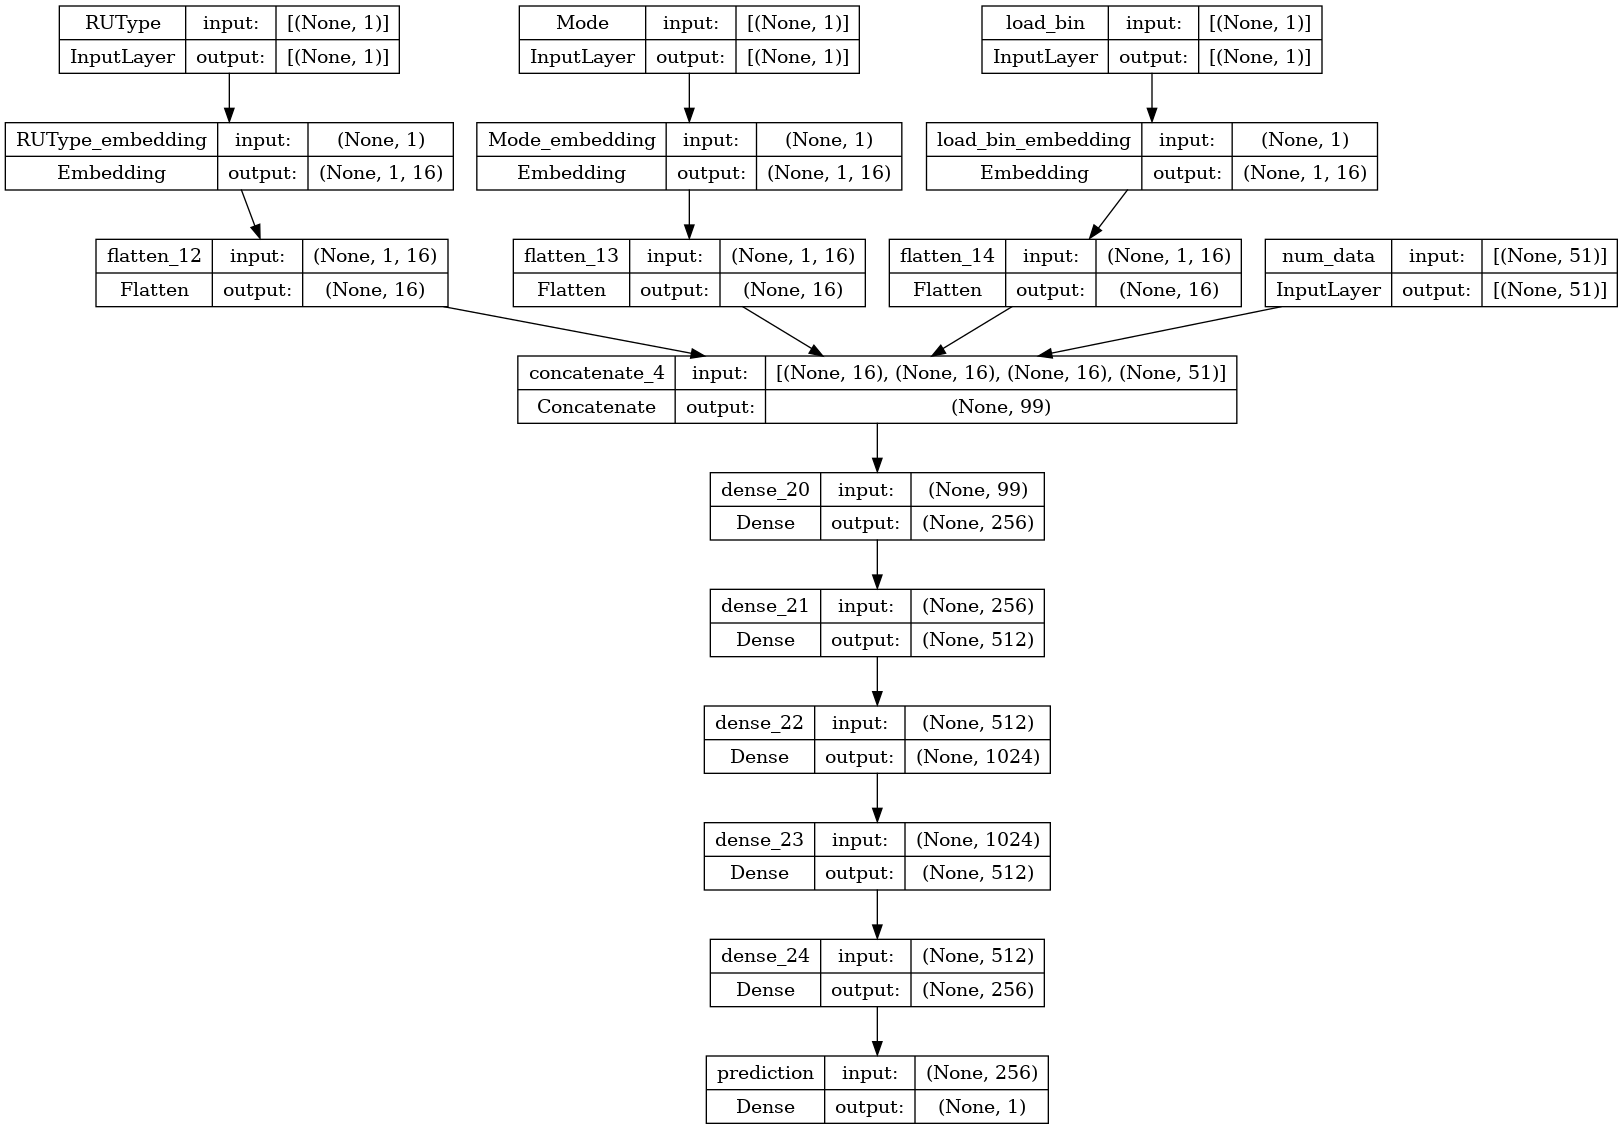

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Main differentiators of the pipeline (will be explained in detail in the report)

1. EDA:
- We see from the EDA that Energy is heavily seasonal with hour of day (as shown by a plot in the training code)
- Along with hour of day, Energy is also positively correlated with load
- From the above two observations, we wanted to make features and model combination such that, for the BS where we have the history, the model is able to capture the hourly pattern from past data and for new BS the same model is able to capture variations due to change in load and other physical configurations. 

2. Spline transformation for hour column instead of trigonometric transformation.
- The raw ordinal time-related features are problematic because they do not capture the natural periodicity.we observe a big jump in the predictions at the end of each day when the hour features goes from 23 back to 0
- As expected, the trigonometric features (sine and cosine) do not have these discontinuities at midnight, but the ANN model fails to leverage those features to properly model intra-day variations. Using trigonometric features for higher harmonics or additional trigonometric features for the natural period with different phases could potentially fix this problem.
- The periodic spline-based features fix those two problems at once: they give more expressivity to the ANN model by making it possible to focus on specific hours thanks to the use of 12 splines. Furthermore the extrapolation="periodic" option enforces a smooth representation between hour=23 and hour=0

3. Smoothening features (savgol filter and SOS filter)
- In the code, neither the Savitzky-Golay filter (SG filter) nor the Butterworth filter (SOS filter) use future data directly. They both operate on a sliding window or causal basis, which means they use only past and current data to filter the signal.
- For the Savitzky-Golay filter, the sg function is applied to each data point using a specified window length and polynomial order. It calculates a smoothed value for each point based on the data within the window, which includes both past and current values. There is no knowledge of future data points.
- Similarly, for the Butterworth filter using the sosfiltfilt and sosfilt functions, they also operate in a causal manner. The sosfiltfilt function is designed for zero-phase filtering, meaning it applies the filter forward and backward to minimize phase distortion, but it still operates causally using only past and current data. The sosfilt function filters the data using the given initial conditions (zi) and also operates causally.
- So, in both cases, these filters don't directly access or use future data points for filtering. They process data in a way that doesn't require knowledge of what will come in the future.
- Savitzky-Golay Filtering (SG Filter):
    - In our research, we utilized Savitzky-Golay filtering to enhance the quality of our noisy data. This technique, implemented through the sg function, applies a polynomial smoothing filter to the dataset. By specifying the window length and polynomial order, we were able to obtain different derivative orders and a smoothed version of the data. The 'load_smooth' feature represents the smoothed signal, while 'load_diff,' 'load_diff2,' and 'load_diff3' capture the first, second, and third-order derivatives, respectively. This approach not only reduces noise but also extracts valuable insights from the underlying data, making it a crucial tool in our research for characterizing complex signal dynamics.
- Second-Order Section (SOS) Filtering:
    - To further advance our signal processing capabilities, we harnessed the power of Butterworth filtering with second-order section (SOS) design. The add_sosfiltfilt function employs both fourth and eighth-order Butterworth filters to modify the 'load' data in our study. This filtering approach, facilitated by the sosfiltfilt and sosfilt functions, operates causally, and no knowledge of future data points is required. The 'load_sosfiltfilt' and 'load_sosfilt' features reflect the outcomes of this filtering. By varying the filter order and cutoff frequency, we were able to adapt the SOS filter to various research scenarios, enhancing the quality and interpretability of our dataset. This technique is instrumental for researchers seeking to isolate specific frequency components or suppress noise from time series data while preserving causality.

4. Swish Activation function instead of ReLU (in the best performing model [Keras])
    - In simple terms, the SiLU (Sigmoid-weighted Linear Unit) activation function worked better than ReLU for our tabular regression problem because of its unique properties:

        - Non-Monotonic Behavior: Unlike ReLU, SiLU doesn't always increase as its input gets larger. It has a global minimum value around -0.28, which means it can inhibit the growth of weights that are too large. This prevents our neural network from learning weight values that are too extreme, which can lead to overfitting.

        - Implicit Regularization: The global minimum of SiLU serves as a "soft floor" on the weights, effectively acting as an implicit regularizer. This encourages our neural network to maintain weights at reasonable magnitudes, which is beneficial for generalization and prevents overfitting.

        - Similarity to ReLU for Large Inputs: When the input values to SiLU are large, its behavior is similar to ReLU. This means that SiLU can still capture the beneficial features of ReLU when the inputs have large magnitudes.

    In essence, SiLU combines the advantages of ReLU (encouraging sparsity and faster convergence) with a self-stabilizing mechanism that prevents extreme weight values. This lead to better performance in our tabular regression problem, where controlling the scale of weights was crucial for achieving good results without overfitting.

5. Using GroupKFold instead of StratifiedKfold to ensure that validation in each fold is done on the BS which is not present in the training data of that fold, to make the model generalize well across BS. Also, we didnot use BS as an input to the model and forced it to learn the relationship between physical conguration, past history and Energy.